In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

# Titanic Competition

0. Loading in the data
1. EDA
2. Preprocessing and Feature Engineering
3. Modeling
4. Final Model Diagnostics and Predictions

## 0: Loading in the data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## 1. EDA

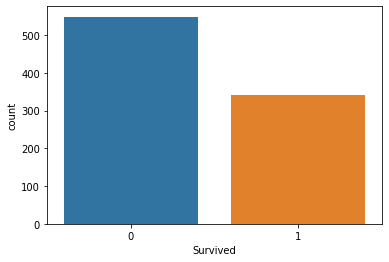

In [5]:
# Some class imbalance, but not extreme
sns.countplot(x='Survived', data=train);

### 1.2 Categorical Features

Relationship between categorical features and the binary response variable

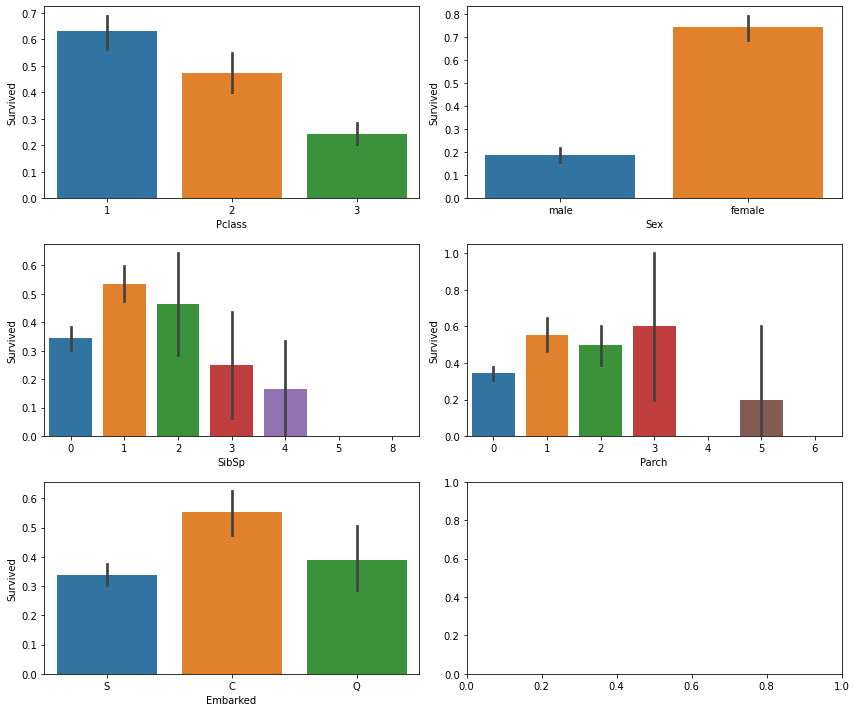

In [6]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10), sharex=False)
sns.barplot(x='Pclass', y='Survived', data=train, ax=ax[0, 0]);
sns.barplot(x='Sex', y='Survived', data=train, ax=ax[0, 1]);
sns.barplot(x='SibSp', y='Survived', data=train, ax=ax[1, 0]);
sns.barplot(x='Parch', y='Survived', data=train, ax=ax[1, 1]);
sns.barplot(x='Embarked', y='Survived', data=train, ax=ax[2, 0]);
fig.tight_layout()

1. Higher classes more likely to survive
2. Females much more likely to survive
3. Passengers with 1 or 2 siblings or spouses more likely to survive
4. Passengers with 1 2 or 3 parents or children more likely to survive
5. Passengers from Cherbourg more likely to survive

In [7]:
# Repeat tickets for same family
print(len(train['Ticket'].unique()))
train['Ticket'].value_counts()

681


1601        7
347082      7
CA. 2343    7
3101295     6
CA 2144     6
           ..
250643      1
3101265     1
226593      1
36209       1
111240      1
Name: Ticket, Length: 681, dtype: int64

In [8]:
# First letter may give an indication of survival?
print(len(train['Cabin'].unique()))
train['Cabin'].unique()[:10]

148


array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78'], dtype=object)

### 1.2 Continuous Features

Relationship between continuous features and the binary response variable

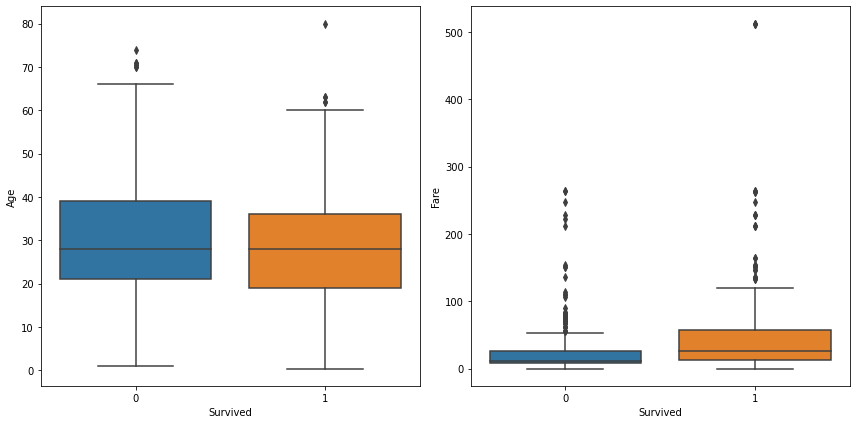

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=False)
sns.boxplot(x='Survived', y='Age', data=train, ax=ax[0]);
sns.boxplot(x='Survived', y='Fare', data=train, ax=ax[1]);
plt.tight_layout();

1. Not much differentiation, but appears that non-survivors were slightly older
2. A good amount of outliers, but survivors had a higher fare

### 1.3 Name

In [10]:
train['Name'].unique()[:20]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima'], dtype=object)

## 2. Preproccessing and Feature Engineering

### 2.1 Replacing Missing Data

In [11]:
def replace_age(df):
    """
    Replace missing ages with the Median amongst all passengers with the same title
    - if subdf is empty, then replace with overall Median
    """
    replaced = df.copy()
    
    replaced['Title'] = replaced['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    for i in np.arange(len(replaced)):
        age = replaced.loc[i, 'Age']
        if pd.isnull(age):
            title = replaced.loc[i, 'Title']
            sub_df = replaced[replaced['Title'] == title]
            if sum(~sub_df['Age'].isna()) == 0:
                replaced.loc[i, 'Age'] = np.nanmedian(replaced['Age'])
            else:
                replaced.loc[i, 'Age'] = np.nanmedian(sub_df['Age'])
    replaced = replaced.drop(['Title'], axis=1)
    
    return replaced

In [12]:
def replace_fare(df):
    """
    Replace missing fare with the Median amongst all passengers from the same class
    """
    replaced = df.copy()

    for i in np.arange(len(replaced)):
        fare = replaced.loc[i, 'Fare']
        if pd.isnull(fare):
            pclass = replaced.loc[i, 'Pclass']
            sub_df = replaced[replaced['Pclass'] == pclass]
            replaced.loc[i, 'Fare'] = np.nanmedian(sub_df['Fare'])

    return replaced

### 2.2 New Features

1. Title
2. Cabin
3. Alone
4. Age Group
5. Fare Group

In [13]:
train_titles = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train_titles.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Countess      1
Capt          1
Don           1
Ms            1
Jonkheer      1
Mme           1
Sir           1
Lady          1
Name: Name, dtype: int64

In [14]:
# Noticed several titles in name column
def add_title(df):
    """
    Take in dataframe with Name column, extract titles as features
    - OHE titles according to context of the title (see dictionary)
    - some titles are encoding errors of other titles
    Return cleaned dataframe
    """
    cleaned = df.copy()
    cleaned['Title'] = cleaned['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)    
    
    Title_Dictionary = {
        "Capt": "Officer",
        "Col": "Officer",
        "Major": "Officer",
        "Jonkheer": "Royalty",
        "Don": "Royalty",
        "Sir" : "Royalty",
        "Dr": "Officer",
        "Rev": "Officer",
        "the Countess":"Royalty",
        "Mme": "Mrs",
        "Mlle": "Miss",
        "Ms": "Mrs",
        "Mr" : "Mr",
        "Mrs" : "Mrs",
        "Miss" : "Miss",
        "Master" : "Master",
        "Lady" : "Royalty"
    }
    cleaned['Title'] = cleaned['Title'].map(Title_Dictionary)
    
    return cleaned

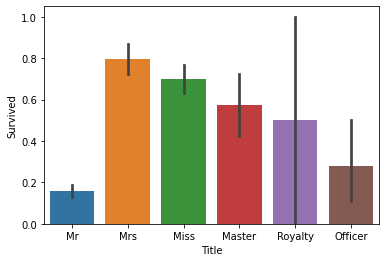

In [15]:
# Evidence that survival probability differs with title
train_withName = add_title(train)
sns.barplot(x='Title', y='Survived', data=train_withName);

In [16]:
# Cabin letters may be some indication, so we extract first letter
def add_cabin(df):
    """
    Add feature denoting Cabins A-G, T
    - Use "U" to denote Unknown cabin
    
    Use ordinal encoding to take advantage of the order of cabins
    
    Return cleaned dataframe
    """
    cleaned = df.copy()   
    cleaned['Cabin'] = cleaned['Cabin'].str[0]
    cleaned['Cabin'] = cleaned['Cabin'].fillna("U")
    
    cabin_map = {'T': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 
                 'E': 5, 'F': 6, 'G': 7, 'U': 8}
    
    cleaned['Cabin'] = cleaned['Cabin'].map(cabin_map)
    
    return cleaned

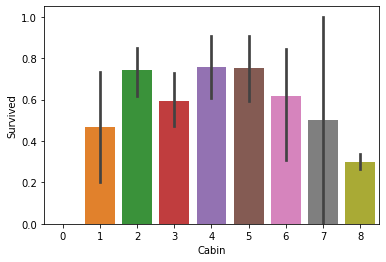

In [17]:
# Evidence that survival probability differs with Cabin
train_withCabin = add_cabin(train)
sns.barplot(x='Cabin', y='Survived', data=train_withCabin);

In [18]:
def add_alone(df):
    """
    Researched that passengers who traveled alone were less likely to survive
    Create binary variable that denotes "Alone"
    """
    cleaned = df.copy()
    cleaned['familySize'] = cleaned['SibSp'] + cleaned['Parch']
    # Alone Column - no sibsp and no parch
    cleaned['Alone'] = [1 if x == 0 else 0 for x in cleaned['familySize']]
    
    return cleaned

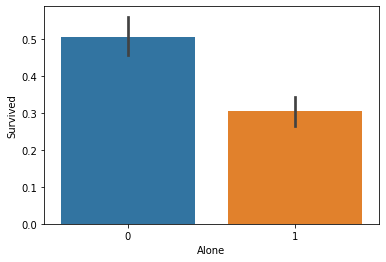

In [19]:
# Evidence that survival probability differs by Alone
train_withAlone = add_alone(train)
sns.barplot(x='Alone', y='Survived', data=train_withAlone);

In [20]:
def age_groups(df):
    """
    Bin passengers into different age groups 
    """
    cleaned = df.copy()
    
    cleaned['AgeGroup'] = pd.cut(df['Age'], 6, labels = ["Children", "Adolescents", 
                            "Young Adults","Adults", "Seniors", "Elders"])
    
    return cleaned

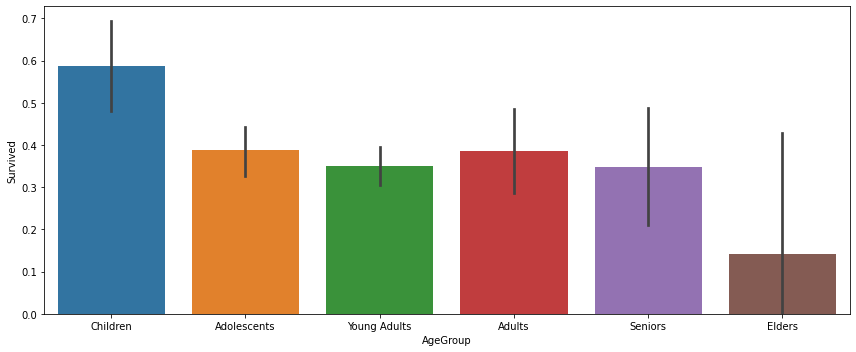

In [21]:
# Evidence that survival probability differs by Age group
train_withAge = replace_age(train)
train_withAge = age_groups(train_withAge)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='AgeGroup', y='Survived', data=train_withAge, ax=ax);
fig.tight_layout()

In [22]:
def fare_groups(df):
    """
    Bin passengers into different fare groups 
    """
    cleaned = df.copy()
    
    cut_points = train['Fare'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
    cleaned['fareGroup'] = pd.cut(df['Fare'], bins=cut_points, labels = ["Low", "LowerMiddle", 
                            "Middle","Upper", "Wealthy"])
    
    return cleaned

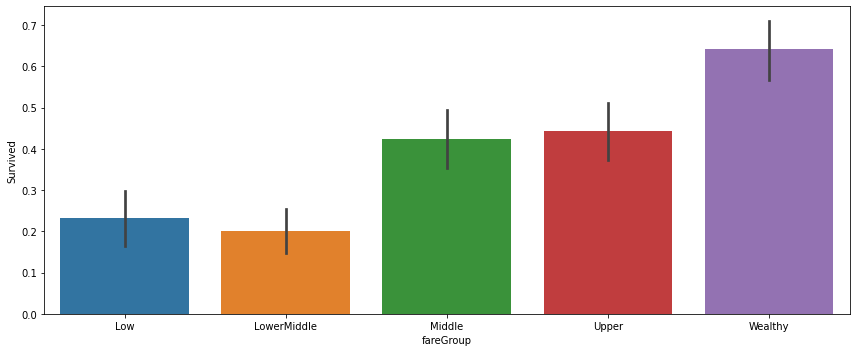

In [23]:
# Evidence that survival probability differs by Fare group
train_withFare = fare_groups(train)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='fareGroup', y='Survived', data=train_withFare, ax=ax);
fig.tight_layout()

### 2.3 Preprocessing

In [24]:
def preProcess(train, test):
    """
    Preprocess Raw Dataframe into design matrix (w/ response column)
    - concatenate train and test as joint dataframe to maximize signal in all data for standardization
    """
    y_train = train['Survived']
    train = train.drop(['Survived'], axis=1)
    train_ids = train['PassengerId']
    
    processed = pd.concat([train, test])
    processed = processed.reset_index()
    processed = processed.drop(['index'], axis=1)

    processed = replace_age(processed)
    processed = replace_fare(processed)
    # Fill embarked with majority class (only two NA)
    processed['Embarked'] = processed['Embarked'].fillna('S')
    
    # New Features
    processed = add_title(processed)
    processed = add_cabin(processed)
    processed = add_alone(processed)
    processed = age_groups(processed)
    processed = fare_groups(processed)
    
    # OHE
    features = ['Embarked', 'Sex', 'AgeGroup', 'Title', 'fareGroup']
    for feature in features:
        dummies = pd.get_dummies(processed[feature], prefix=feature, prefix_sep='_')
        processed = processed.join(dummies)
    
    # Scale Fare by family size to get cost per ticket
    processed['Fare_per_person'] = processed['Fare'] / (processed['familySize'] + 1)
    
    # Drop Unecessary columns
    # Drop Ticket to avoid overfitting
    processed = processed.drop(['Ticket', 'Name', 'Title', 'Embarked', 
                                'Sex', 'AgeGroup', 'fareGroup'], axis=1)
        
    # Standardize Continuous Features
    standard_scaler = StandardScaler()
    numerical_features = ['SibSp', 'Parch', 'Fare', 'Fare_per_person', 'Age', 
                          'Cabin', 'Pclass', 'familySize']
    processed[numerical_features] = standard_scaler.fit_transform(
                                            processed[numerical_features])
    
    # Separate back into train and test
    train_df = processed[processed['PassengerId'].isin(train_ids)]
    train_df = train_df.drop(['PassengerId'], axis=1)
    train_df['Survived'] = y_train
    
    test_df = processed[~processed['PassengerId'].isin(train_ids)]
    test_df = test_df.drop(['PassengerId'], axis=1)
    
    return train_df, test_df

In [25]:
trainClean, testClean = preProcess(train, test)
trainClean.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,familySize,Alone,Embarked_C,Embarked_Q,...,Title_Mrs,Title_Officer,Title_Royalty,fareGroup_Low,fareGroup_LowerMiddle,fareGroup_Middle,fareGroup_Upper,fareGroup_Wealthy,Fare_per_person,Survived
0,0.841916,-0.564835,0.481288,-0.445,-0.503176,0.509153,0.073352,0,0,0,...,0,0,0,1,0,0,0,0,-0.472289,0
1,-1.546098,0.651087,0.481288,-0.445,0.734809,-1.912654,0.073352,0,1,0,...,1,0,0,0,0,0,0,1,0.423315,1
2,0.841916,-0.260855,-0.479087,-0.445,-0.490126,0.509153,-0.558346,1,0,0,...,0,0,0,0,1,0,0,0,-0.352005,1
3,-1.546098,0.423101,0.481288,-0.445,0.383263,-1.912654,0.073352,0,0,0,...,1,0,0,0,0,0,0,1,0.168994,1
4,0.841916,0.423101,-0.479087,-0.445,-0.487709,0.509153,-0.558346,1,0,0,...,0,0,0,0,1,0,0,0,-0.348508,0


In [26]:
print(f'Features: {trainClean.columns.values}')

Features: ['Pclass' 'Age' 'SibSp' 'Parch' 'Fare' 'Cabin' 'familySize' 'Alone'
 'Embarked_C' 'Embarked_Q' 'Embarked_S' 'Sex_female' 'Sex_male'
 'AgeGroup_Children' 'AgeGroup_Adolescents' 'AgeGroup_Young Adults'
 'AgeGroup_Adults' 'AgeGroup_Seniors' 'AgeGroup_Elders' 'Title_Master'
 'Title_Miss' 'Title_Mr' 'Title_Mrs' 'Title_Officer' 'Title_Royalty'
 'fareGroup_Low' 'fareGroup_LowerMiddle' 'fareGroup_Middle'
 'fareGroup_Upper' 'fareGroup_Wealthy' 'Fare_per_person' 'Survived']


## 3. Feature Selection Modeling

Because the training data contains only 891 rows, I decided to avoid more complex models, such as neural networks. Without extensive tuning, they would be very prone to overfitting on a small dataset. Simpler models, such as Logistic Regression, Random Forest, and K Nearest Neighbor models can be more easily optimized, and are less prone to overfitting.

Still, the above dataframe contains a sizeable amount of features, relative to the size of the dataset (<1000 data points). Thus, we will use feature selection methods to reduce the feature space for each model.

In [27]:
Y_train = trainClean['Survived']
X_train = trainClean.drop(['Survived'], axis=1)

In [28]:
def cross_val_acc(model, X_train, Y_train, k):
    '''
    Compute k-fold Cross Validation accuracy

    Inputs:
        model: an sklearn model with fit and predict functions 
        X_train: Design Matrix
        Y_train: Response Vector
    Outputs:
        the average validation Accuracy for the k splits.
    '''
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    validation_accuracies = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit model
        model.fit(split_X_train, split_Y_train)
        
        # Compute Accuracy on the validation split
        acc = model.score(split_X_valid, split_Y_valid)
        validation_accuracies.append(acc)
        
    return np.mean(validation_accuracies)

**For each model below, we will preprocess the design matrix with feature selection (when applicable), then investigate the baseline model (without tuning)**

In [29]:
# Initialize
K = 5
RANDOM_STATE = 0

### 3.1 Logistic Regression

In [30]:
selector = SelectFromModel(estimator=LogisticRegression()).fit(X_train, Y_train)
X_train_lr = X_train.loc[:, selector.get_support()]

In [31]:
logreg = LogisticRegression(random_state=RANDOM_STATE)

cv_acc = cross_val_acc(logreg, X_train_lr, Y_train, K)
print(f'Logistic Regression {K} Fold CV Accuracy = {cv_acc}')

logreg.fit(X_train_lr, Y_train)
print(f'Logistic Regression Training Accuracy = {logreg.score(X_train_lr, Y_train)}')

Logistic Regression 5 Fold CV Accuracy = 0.8170673529596385
Logistic Regression Training Accuracy = 0.819304152637486


### 3.2 Random Forest

In [32]:
selector = SelectFromModel(estimator=RandomForestClassifier(random_state=RANDOM_STATE)).fit(X_train, Y_train)
X_train_rf = X_train.loc[:, selector.get_support()]

In [33]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)

cv_acc = cross_val_acc(rf, X_train_rf, Y_train, K)
print(f'Random Forest {K} Fold CV Accuracy = {cv_acc}')

rf.fit(X_train_rf, Y_train)
print(f'Random Forest Training Accuracy = {rf.score(X_train_rf, Y_train)}')

Random Forest 5 Fold CV Accuracy = 0.8181783943255289
Random Forest Training Accuracy = 0.9831649831649831


### 3.3 K Nearest Neighbors

In [34]:
knn = KNeighborsClassifier(n_neighbors=5)
cv_acc = cross_val_acc(knn, X_train, Y_train, K)
print(f'K-Nearest Neighbors {K} Fold CV Accuracy = {cv_acc}')

knn.fit(X_train, Y_train)
print(f'K-Nearest Neighbors Training Accuracy = {knn.score(X_train, Y_train)}')

K-Nearest Neighbors 5 Fold CV Accuracy = 0.8103320569957944
K-Nearest Neighbors Training Accuracy = 0.8574635241301908


### 3.4 Support Vector Classifier

Used LinearSVC for feature selection, then used SVC as classifier.

In [35]:
selector = SelectFromModel(estimator=LinearSVC(random_state=RANDOM_STATE, 
                                               max_iter=50000)).fit(X_train, Y_train)
X_train_svc = X_train.loc[:, selector.get_support()]

In [36]:
svc = SVC(random_state=RANDOM_STATE)

cv_acc = cross_val_acc(svc, X_train_svc, Y_train, K)
print(f'Support Vector Classifier {K} Fold CV Accuracy = {cv_acc}')

svc.fit(X_train_svc, Y_train)
print(f'Support Vector Classifier Training Accuracy = {svc.score(X_train_svc, Y_train)}')

Support Vector Classifier 5 Fold CV Accuracy = 0.7901198920343984
Support Vector Classifier Training Accuracy = 0.8002244668911336


### 3.5 Gaussian Naive Bayes

In [37]:
gnb = GaussianNB()

cv_acc = cross_val_acc(gnb, X_train, Y_train, K)
print(f'Gaussian Naive Bayes {K} Fold CV Accuracy = {cv_acc}')

gnb.fit(X_train, Y_train)
print(f'Gaussian Naive Bayes Training Accuracy = {gnb.score(X_train, Y_train)}')

Gaussian Naive Bayes 5 Fold CV Accuracy = 0.7766241918272551
Gaussian Naive Bayes Training Accuracy = 0.7934904601571269


### 3.6 Hyperparameter Tuning

There is overfitting in all cases with the baseline models, so we will perform hyperparameter tuning

In [38]:
def gridSearch(pipe, param_grid, X_train, Y_train, K):
    """
    Returns best hyperparameters for a particular model based on training data
    """
    # Create grid search object
    clf = GridSearchCV(pipe, param_grid=param_grid, cv=K, 
                       scoring='accuracy', verbose=True, n_jobs=-1)
    # Fit on data
    best_model = clf.fit(X_train, Y_train)
    
    return best_model

In [39]:
def display_results(model, name, X):
    """
    Show confusion matrix for model with tuned hyperparameters for given design matrix
    """
    # Confusion Matrix for Logistic Regression on Training Data
    print(f'Best {name} CV Accuracy = ', model.best_score_)
    ## Have more False Positives that False Negatives
    y_pred = model.predict(X)
    sns.heatmap(confusion_matrix(Y_train, y_pred), annot=True);
    plt.ylabel('Actual');
    plt.xlabel('Predicted');
    plt.title(f'{name} Confusion Matrix on Training Data')

In [40]:
# Find Best Logistic Regression
pipe = Pipeline([('classifier' , LogisticRegression(random_state=RANDOM_STATE, 
                                                    max_iter=1500))])

# Create param grid.
param_grid = [
    {'classifier' : [LogisticRegression(random_state=RANDOM_STATE, max_iter=1500)],
     'classifier__penalty' : ['l1', 'l2', 'elasticnet'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['saga']}
]

# Fit on data
best_logreg = gridSearch(pipe, param_grid, X_train_lr, Y_train, K)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.5s finished


In [41]:
best_logreg.best_estimator_.get_params()['classifier']

LogisticRegression(C=0.23357214690901212, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

Best Logistic Regression CV Accuracy =  0.8170610758897746


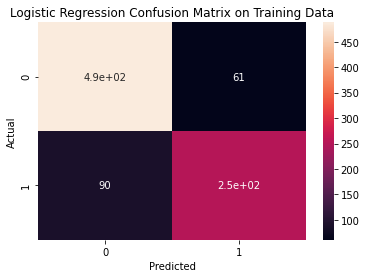

In [42]:
display_results(best_logreg, "Logistic Regression", X_train_lr)

In [43]:
# Find Best Random Forest
pipe = Pipeline([('classifier' , RandomForestClassifier(random_state=RANDOM_STATE))])

num_features = len(X_train.columns.values)

# Create param grid.
param_grid = [
    {'classifier' : [RandomForestClassifier(random_state=RANDOM_STATE)],
    'classifier__n_estimators' : np.arange(100, 201, 10),
    'classifier__max_features' : [None], # chose none since we already did feature selection
    'classifier__max_depth' : np.arange(7, 12),
    'classifier__min_samples_leaf' : np.arange(1, 4),
    'classifier__min_samples_split' : np.arange(1, 4),
    'classifier__oob_score' : [True, False]}
]

# Fit on data
best_rf = gridSearch(pipe, param_grid, X_train_rf, Y_train, K)

Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 510 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 860 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1310 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1860 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2510 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3260 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 4110 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed: 12.1min finished


In [44]:
best_rf.best_estimator_.get_params()['classifier']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

Best Random Forest CV Accuracy =  0.8484840876278954


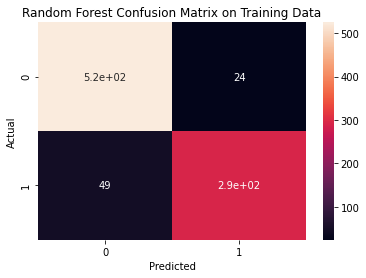

In [45]:
display_results(best_rf, "Random Forest", X_train_rf)

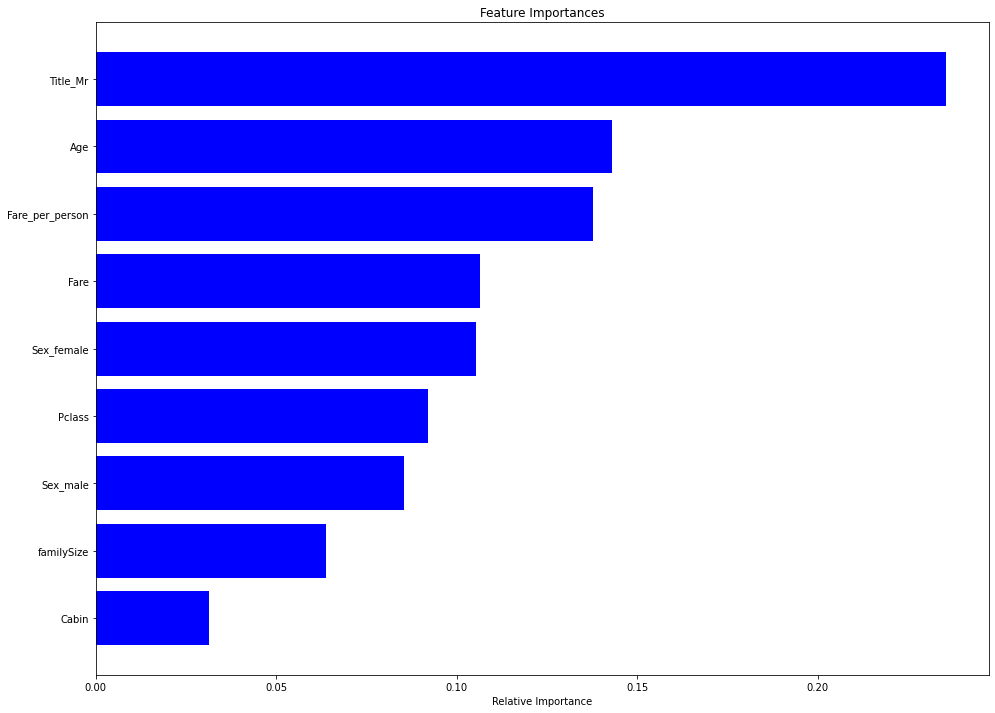

In [46]:
# Analyze Feature Importances
random_forest = best_rf.best_estimator_.get_params()['classifier']
features = X_train_rf.columns.values
importances = random_forest.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [47]:
# Find Best KNN
pipe = Pipeline([('classifier' , KNeighborsClassifier())])

# Create param grid.
param_grid = [
    {'classifier' : [KNeighborsClassifier()],
    'classifier__n_neighbors' : np.arange(3, 100, 2),
    'classifier__weights' : ['uniform', 'distance'],
    'classifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__leaf_size' : np.arange(10, 51, 10)}
]

# Fit on data
best_knn = gridSearch(pipe, param_grid, X_train, Y_train, K)

Fitting 5 folds for each of 1960 candidates, totalling 9800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 1896 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 4696 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 8296 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 9800 out of 9800 | elapsed:  1.3min finished


In [48]:
best_knn.best_estimator_.get_params()['classifier']

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

Best K Nearest Neighbors CV Accuracy =  0.8215742891218378


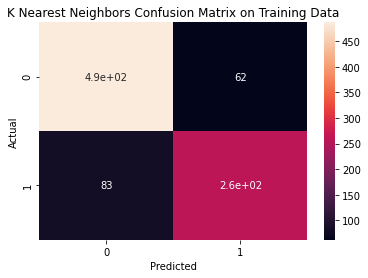

In [49]:
display_results(best_knn, "K Nearest Neighbors", X_train)

In [50]:
# Find Best Support Vector Machine Regression
pipe = Pipeline([('classifier' , SVC(random_state=RANDOM_STATE, 
                                                    max_iter=1500))])

# Create param grid.
param_grid = [{
    'classifier' : [SVC(random_state=RANDOM_STATE, max_iter=1500)],
    'classifier__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__gamma' : ['scale', 'auto'],
    'classifier__class_weight' : ['balanced', None]
}]

# Fit on data
best_svc = gridSearch(pipe, param_grid, X_train_svc, Y_train, K)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   13.0s finished


In [51]:
best_svc.best_estimator_.get_params()['classifier']

SVC(C=0.03359818286283781, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=1500, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

Best Support Vector Classifier CV Accuracy =  0.7968489109283786


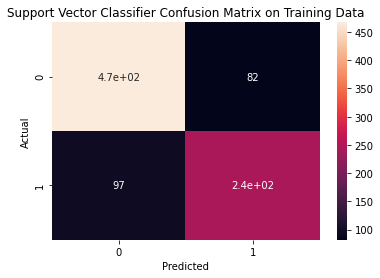

In [52]:
display_results(best_svc, "Support Vector Classifier", X_train_svc)

Best Naive Bayes Accuracy =  0.7934904601571269


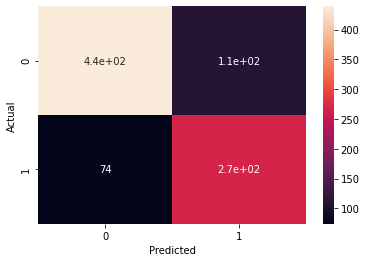

In [53]:
# Confusion Matrix for Naive Bayes Training Data
## No tuning to do - difficult to set priors

print('Best Naive Bayes Accuracy = ', gnb.score(X_train, Y_train))
## Have more False Positives that False Negatives
y_pred = gnb.predict(X_train)
sns.heatmap(confusion_matrix(Y_train, y_pred), annot=True);
plt.ylabel('Actual');
plt.xlabel('Predicted');

## 4. Final Model Diagnostics and Predictions

All models have a few more false negatives, except for Naive Bayes which yields more false positives. However, the optimally tuned models were trained on slightly different design matrices (due to variable selection), and they each capture different characteristics of the passengers. 

Because all tuned models are slightly different but all perform decently well, I decided to use a voting ensemble with each of the five models to yield my final predictions.

In [54]:
lr = best_logreg.best_estimator_.get_params()['classifier']
rf = best_rf.best_estimator_.get_params()['classifier']
knn = best_knn.best_estimator_.get_params()['classifier']
svc = best_svc.best_estimator_.get_params()['classifier']
gnb = gnb

In [55]:
lr_predictions = lr.predict(X_train_lr)
rf_predictions = rf.predict(X_train_rf)
knn_predictions = knn.predict(X_train)
svc_predictions = svc.predict(X_train_svc)
gnb_predictions = gnb.predict(X_train)

train_predictions_df = pd.DataFrame({'Logistic Regression': lr_predictions,
                              'Random Forest': rf_predictions,
                              'K Nearest Neighbors': knn_predictions,
                              'Support Vector Classifier': svc_predictions,
                              'Gaussian Naive Bayes': gnb_predictions})

Training Accuracy of Voting Classifier = 0.8484848484848485


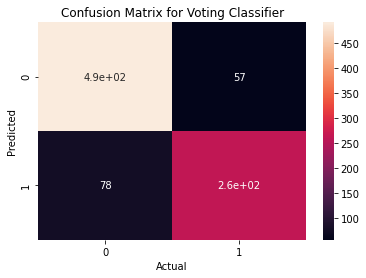

In [56]:
# Confusion Matrix for Voting model on Training Data
y_pred = train_predictions_df.mode(axis=1).iloc[:, 0]
sns.heatmap(confusion_matrix(Y_train, y_pred), annot=True);
acc = np.mean(Y_train==y_pred)
print(f'Training Accuracy of Voting Classifier = {acc}')
plt.ylabel('Predicted');
plt.xlabel('Actual');
plt.title('Confusion Matrix for Voting Classifier');

In [57]:
# Make Final Predictions
X_test_lr = testClean.loc[:, X_train_lr.columns]
X_test_rf = testClean.loc[:, X_train_rf.columns]
X_test_svc = testClean.loc[:, X_train_svc.columns]

lr_predictions = lr.predict(X_test_lr)
rf_predictions = rf.predict(X_test_rf)
knn_predictions = knn.predict(testClean)
svc_predictions = svc.predict(X_test_svc)
gnb_predictions = gnb.predict(testClean)

test_predictions_df = pd.DataFrame({'Logistic Regression': lr_predictions,
                              'Random Forest': rf_predictions,
                              'K Nearest Neighbors': knn_predictions,
                              'Support Vector Classifier': svc_predictions,
                              'Gaussian Naive Bayes': gnb_predictions})


test_preds = test_predictions_df.mode(axis=1).iloc[:, 0]
submission = pd.DataFrame({'PassengerId': test['PassengerId'],
                          'Survived': test_preds})
submission.to_csv('data/submission.csv', index=False)

**Final Results**

78.468% Accuracy on Kaggle Public Leaderboard